In [ ]:
import zipfile

try:
    with zipfile.ZipFile('/content/dataset.zip', 'r') as zip_ref:
        zip_ref.extractall('/content')
except zipfile.BadZipFile:
    print("The file is not a zip file or it is corrupted.")
except FileNotFoundError:
    print("The file was not found. Check the file path.")
except Exception as e:
    print(f"An error occurred: {e}")

In [ ]:
import os
from PIL import Image
import json

def convert_yolo_to_corners(x_center, y_center, width, height, img_width, img_height):
    x_center, width = x_center * img_width, width * img_width
    y_center, height = y_center * img_height, height * img_height
    x_min = x_center - (width / 2)
    y_min = y_center - (height / 2)
    x_max = x_center + (width / 2)
    y_max = y_center + (height / 2)
    return [x_min, y_min, x_max, y_max]

def convert_yolo_annotations(base_dir, subsets):
    for subset in subsets:
        images_dir = os.path.join(base_dir, subset, 'images')
        labels_dir = os.path.join(base_dir, subset, 'labels')
        json_data = []

        for filename in os.listdir(images_dir):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                label_file = os.path.join(labels_dir, filename.rsplit('.', 1)[0] + '.txt')
                image_path = os.path.join(images_dir, filename)
                image = Image.open(image_path)
                img_width, img_height = image.size
                image_data = {
                    'filename': filename,
                    'path': image_path,
                    'boxes': [],
                    'labels': []
                }

                if os.path.exists(label_file):
                    with open(label_file, 'r') as file:
                        for line in file:
                            parts = line.strip().split()
                            class_id = int(parts[0])
                            x_center, y_center, width, height = map(float, parts[1:])
                            box = convert_yolo_to_corners(x_center, y_center, width, height, img_width, img_height)
                            image_data['labels'].append(class_id)
                            image_data['boxes'].append(box)

                json_data.append(image_data)

        with open(os.path.join(base_dir, subset, 'annotations.json'), 'w') as json_file:
            json.dump(json_data, json_file, indent=4)

# Usage
base_dir = '/content/structured_dataset'
subsets = ['train', 'val', 'test']
convert_yolo_annotations(base_dir, subsets)

In [ ]:
import os
from PIL import Image
import json

def update_json_with_dimensions(json_file, img_dir):
    # Load existing data
    with open(json_file, 'r') as f:
        data = json.load(f)

    # Update each entry with image dimensions
    for item in data:
        img_path = os.path.join(img_dir, item['filename'])
        with Image.open(img_path) as img:
            item['original_width'], item['original_height'] = img.size

    # Save updated data
    with open(json_file, 'w') as f:
        json.dump(data, f, indent=4)

# Example usage
base_dir = '/content/structured_dataset/train'
json_file = os.path.join(base_dir, 'annotations.json')
img_dir = os.path.join(base_dir, 'images')
update_json_with_dimensions(json_file, img_dir)
base_dir = '/content/structured_dataset/test'
json_file = os.path.join(base_dir, 'annotations.json')
img_dir = os.path.join(base_dir, 'images')
update_json_with_dimensions(json_file, img_dir)
base_dir = '/content/structured_dataset/val'
json_file = os.path.join(base_dir, 'annotations.json')
img_dir = os.path.join(base_dir, 'images')
update_json_with_dimensions(json_file, img_dir)

In [ ]:
import json
import os

def test_annotation_conversion(base_dir, subset):
    json_file_path = os.path.join(base_dir, subset, 'annotations.json')
    with open(json_file_path, 'r') as file:
        data = json.load(file)

    errors = []
    for item in data:
        # Check for necessary keys
        if not all(key in item for key in ['filename', 'path', 'boxes', 'labels']):
            errors.append(f"Missing keys in item: {item['filename']}")

        # Check bounding box format
        for box in item['boxes']:
            if not len(box) == 4 or not all(isinstance(x, (int, float)) for x in box):
                errors.append(f"Invalid box format in {item['filename']}: {box}")

    return errors

# Usage
base_dir = '/content/structured_dataset'
subsets = ['train', 'val', 'test']
for subset in subsets:
    errors = test_annotation_conversion(base_dir, subset)
    if errors:
        print(f"Errors in {subset}:")
        for error in errors:
            print(error)
    else:
        print(f"No errors found in {subset}. Annotation conversion seems correct.")


No errors found in train. Annotation conversion seems correct.
No errors found in val. Annotation conversion seems correct.
No errors found in test. Annotation conversion seems correct.


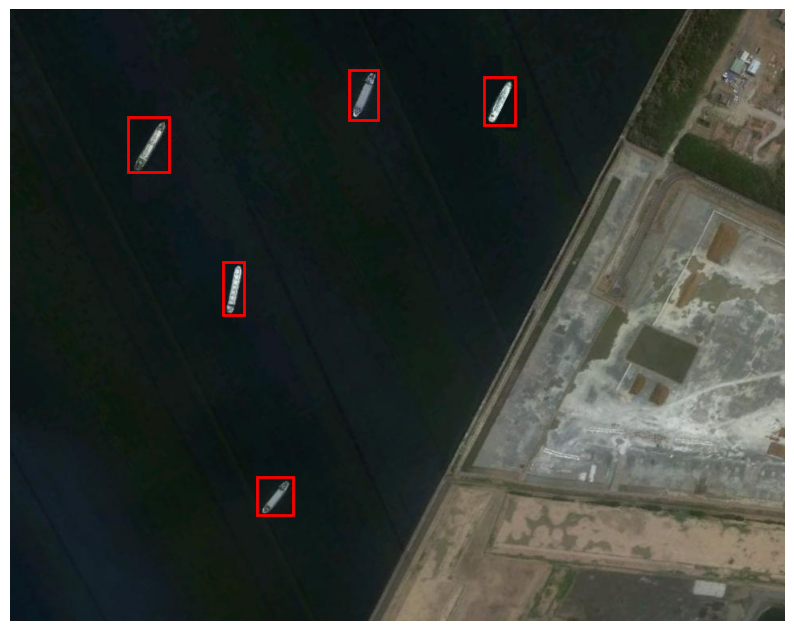

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import json

def visualize_annotations(image_path, boxes):
    """Visualize bounding boxes on an image."""
    image = Image.open(image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()

    for box in boxes:
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()

# Example usage for one image
with open('/content/structured_dataset/train/annotations.json') as f:
    data = json.load(f)
    item = data[0]  # Modify as needed to select different images
    visualize_annotations(item['path'], item['boxes'])

In [ ]:
pip install torch torchvision pillow

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import json
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [ ]:
import torch
import os
import json
from PIL import Image
import torchvision.transforms as transforms

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, json_file, img_dir, transform=None):
        with open(json_file) as f:
            self.data = json.load(f)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_info = self.data[idx]
        img_path = os.path.join(self.img_dir, img_info['filename'])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # Resizing factor, assuming images are resized to (800, 800) during transformation
        original_size = (img_info['original_width'], img_info['original_height'])
        new_size = (800, 800)

        # Adjust bounding boxes
        boxes = []
        for box in img_info['boxes']:
            xmin, ymin, xmax, ymax = box
            xmin = xmin / original_size[0] * new_size[0]
            xmax = xmax / original_size[0] * new_size[0]
            ymin = ymin / original_size[1] * new_size[1]
            ymax = ymax / original_size[1] * new_size[1]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.tensor(boxes, dtype=torch.float32)

        labels = torch.tensor(img_info['labels'], dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        return image, target

# Example transformation (resizing and normalization)
transform = transforms.Compose([
    transforms.Resize((800, 800)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
def custom_collate_fn(batch):
    # Filter out any samples that may have been returned as None
    batch = [data for data in batch if data is not None]

    # Extract images and targets from the batch
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    # Since images are likely the same size (assuming the same transforms were applied), you can stack them
    images = torch.stack(images, dim=0)

    # Do not attempt to stack targets directly since they might have different lengths
    # Simply leave them as a list of dictionaries
    return images, targets
# Example usage
base_dir = '/content/structured_dataset'
train_json = os.path.join(base_dir, 'train', 'annotations.json')
val_json = os.path.join(base_dir, 'val', 'annotations.json')
test_json = os.path.join(base_dir, 'test', 'annotations.json')
train_img_dir = os.path.join(base_dir, 'train', 'images')
val_img_dir = os.path.join(base_dir, 'val', 'images')
test_img_dir = os.path.join(base_dir, 'test', 'images')

# Create datasets
train_dataset = CustomDataset(train_json, train_img_dir, transform)
val_dataset = CustomDataset(val_json, val_img_dir, transform)
test_dataset = CustomDataset(test_json, test_img_dir, transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False, collate_fn=custom_collate_fn)

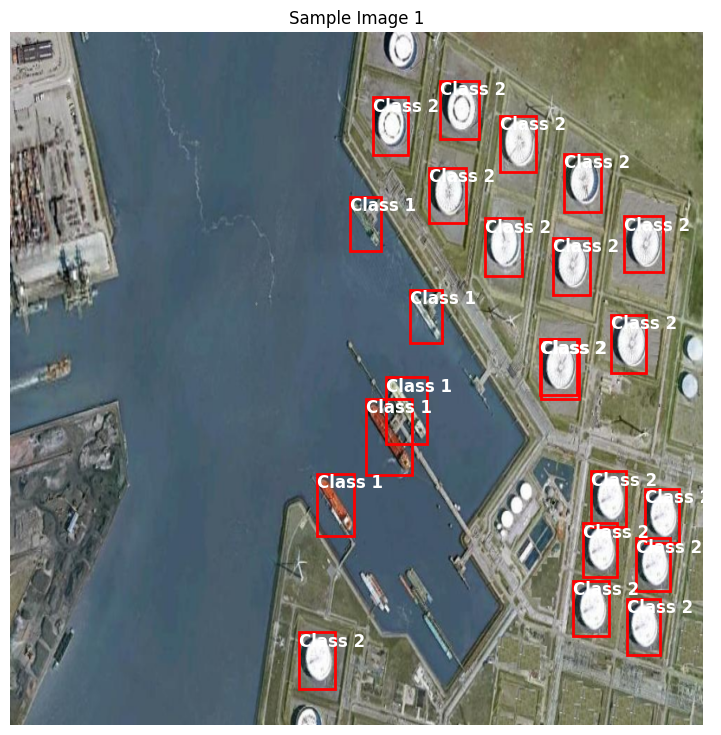

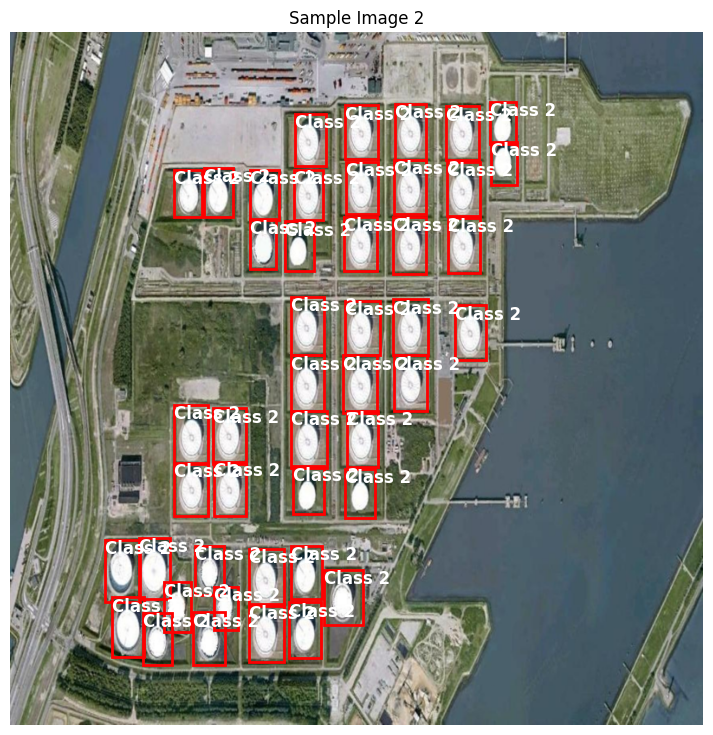

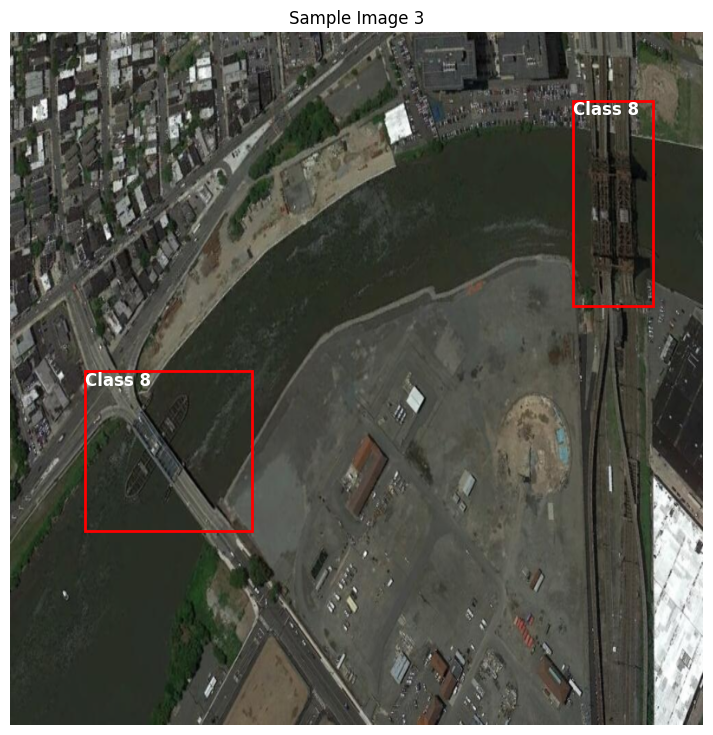

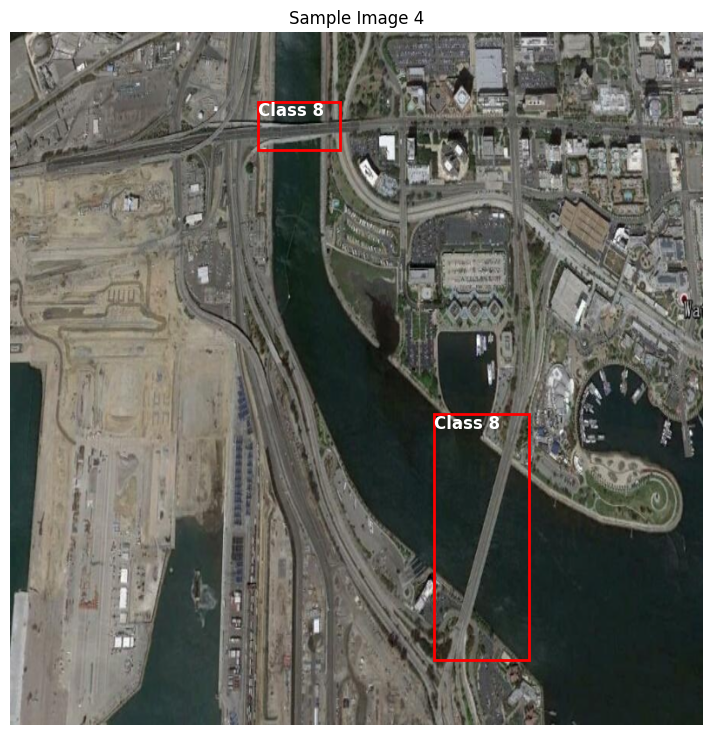

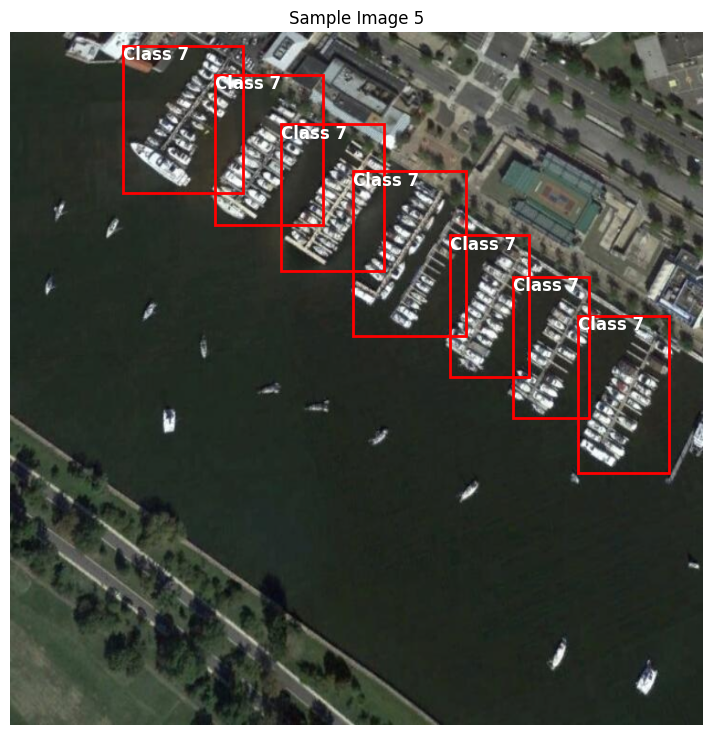

In [ ]:
# Visualization function as defined previously
def show_image_with_boxes(image, target, title=""):
    image = image.permute(1, 2, 0)  # Change C,H,W to H,W,C for matplotlib
    image = (image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])).clamp(0, 1)

    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)
    for box, label in zip(target['boxes'], target['labels']):
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, edgecolor='r', linewidth=2, facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin, f'Class {label}', verticalalignment='top', color='white', fontsize=12, weight='bold')

    plt.title(title)
    plt.axis('off')
    plt.show()

# Testing the data loading and visualization
for images, targets in val_loader:
    for i in range(min(len(images), 5)):  # Display up to 3 images from the dataset
        show_image_with_boxes(images[i], targets[i], title=f"Sample Image {i + 1}")
    break  # Only process the first batch

In [ ]:
# Example usage
for images, targets in train_loader:
    # Your training logic here
    print(images.shape, targets)

torch.Size([10, 3, 800, 800]) [{'boxes': tensor([[225.9481, 396.4602, 352.0958, 546.5486],
        [463.0739, 250.6195, 594.0120, 450.2655]]), 'labels': tensor([8, 8]), 'image_id': tensor([139]), 'area': tensor([18933.3145, 26141.2695]), 'iscrowd': tensor([0, 0])}, {'boxes': tensor([[190.2760, 210.1313, 500.3942, 406.7542]]), 'labels': tensor([6]), 'image_id': tensor([348]), 'area': tensor([60976.3516]), 'iscrowd': tensor([0])}, {'boxes': tensor([[443.8964, 188.4112, 645.1295, 311.0280]]), 'labels': tensor([8]), 'image_id': tensor([434]), 'area': tensor([24674.5586]), 'iscrowd': tensor([0])}, {'boxes': tensor([[739.0826, 558.0872, 762.5688, 605.3446],
        [697.9816, 438.8186, 725.8716, 492.8270],
        [651.7431, 319.5499, 677.4312, 372.4332],
        [176.8807, 181.1533, 211.3761, 228.4107],
        [ 74.1284, 671.7300, 110.0917, 726.8636],
        [263.4862,  79.8875, 295.0459, 122.6442],
        [582.7523, 139.5218, 610.6422, 181.1533],
        [609.1743, 211.5331, 636.3303, 2

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def create_model(num_classes):
    # Load a pre-trained model
    backbone = resnet_fpn_backbone('resnet50', pretrained=True)

    # Correctly configure the anchor generator
    anchor_generator = AnchorGenerator(
        sizes=((32,), (64,), (128,), (256,), (512,)),  # One size for each feature map
        aspect_ratios=((0.5, 1.0, 2.0),) * 5  # Same aspect ratios for each feature map level
    )

    # Create the Faster R-CNN model
    model = FasterRCNN(backbone,
                       num_classes=num_classes,
                       rpn_anchor_generator=anchor_generator)

    # Replace the classifier with a new one for your specific number of classes (including the background)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Number of classes (e.g., 10 classes + 1 background)
num_classes = 11
model = create_model(num_classes)

# Example optimizer
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676

In [ ]:
import torch
from torchvision.models.detection import FasterRCNN
from torchvision.transforms import functional as F
import numpy as np
from torch.utils.data import DataLoader

# Assume 'model' and 'optimizer' are already defined and configured
# Assume 'train_loader' and 'val_loader' are defined DataLoader instances for your training and validation datasets

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Number of epochs to train for
num_epochs = 30

def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    running_loss = 0.0
    for images, targets in data_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    return running_loss / len(data_loader)

def evaluate(model, data_loader, device):
    model.eval()
    running_loss = 0.0
    total = 0
    with torch.no_grad():
        for images, targets in data_loader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Ensure model is in evaluation mode which might change its return values
            model.eval()
            outputs = model(images, targets)

            # If model returns a dictionary of losses (which is typical during training)
            if isinstance(outputs, dict):
                losses = sum(loss for loss in outputs.values())
                running_loss += losses.item()
                total += 1

    return running_loss / total if total > 0 else 0

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, optimizer, train_loader, device)
    val_loss = evaluate(model, val_loader, device)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch 1/30, Train Loss: 0.1522, Validation Loss: 0.0000
Epoch 2/30, Train Loss: 0.1564, Validation Loss: 0.0000
Epoch 3/30, Train Loss: 0.1702, Validation Loss: 0.0000
Epoch 4/30, Train Loss: 0.1562, Validation Loss: 0.0000
Epoch 5/30, Train Loss: 0.1573, Validation Loss: 0.0000
Epoch 6/30, Train Loss: 0.1507, Validation Loss: 0.0000
Epoch 7/30, Train Loss: 0.1355, Validation Loss: 0.0000
Epoch 8/30, Train Loss: 0.1323, Validation Loss: 0.0000
Epoch 9/30, Train Loss: 0.1355, Validation Loss: 0.0000
Epoch 10/30, Train Loss: 0.1413, Validation Loss: 0.0000
Epoch 11/30, Train Loss: 0.1345, Validation Loss: 0.0000
Epoch 12/30, Train Loss: 0.1380, Validation Loss: 0.0000
Epoch 13/30, Train Loss: 0.1306, Validation Loss: 0.0000
Epoch 14/30, Train Loss: 0.1237, Validation Loss: 0.0000
Epoch 15/30, Train Loss: 0.1348, Validation Loss: 0.0000
Epoch 16/30, Train Loss: 0.1213, Validation Loss: 0.0000
Epoch 17/30, Train Loss: 0.1258, Validation Loss: 0.0000
Epoch 18/30, Train Loss: 0.1159, Validat

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, collate_fn=custom_collate_fn)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [ ]:
model.load_state_dict(torch.load('model_30.pt', map_location=torch.device('cpu')))


<All keys matched successfully>

In [ ]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold :
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [ ]:
with torch.no_grad():
    # batch size of the test set = 2
    for imgs, annotations in test_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        print(pred)
        break

[{'boxes': tensor([[708.2478, 374.2436, 736.4758, 425.8307],
        [676.6415, 284.9825, 713.4199, 325.5381],
        [362.8063, 368.1851, 398.7778, 413.6637],
        [240.1066, 262.5546, 279.3141, 310.8494],
        [470.4384, 456.1789, 510.2925, 508.2644],
        [644.5394, 392.5385, 675.3666, 426.3721],
        [667.3390, 319.5876, 703.1431, 358.9649],
        [652.5935, 337.3642, 692.0131, 370.4748],
        [658.2175, 313.8205, 699.5626, 373.5206],
        [670.3651, 288.3154, 709.4150, 346.0487]]), 'labels': tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9]), 'scores': tensor([0.9952, 0.9930, 0.9891, 0.9843, 0.9821, 0.9590, 0.9458, 0.9316, 0.8758,
        0.8199])}, {'boxes': tensor([[508.2710, 543.9249, 533.2300, 582.3902]]), 'labels': tensor([1]), 'scores': tensor([0.6761])}, {'boxes': tensor([[550.5434, 378.7939, 586.2094, 431.2302],
        [227.5708, 655.3842, 258.9486, 710.2915]]), 'labels': tensor([2, 9]), 'scores': tensor([0.9912, 0.5081])}, {'boxes': tensor([[413.0615,  87.6258, 

In [ ]:
import torch

def make_prediction(model, images, device, threshold=0.5):
    # Ensure the model is in evaluation mode
    model.eval()

    # Move images to the correct device
    images = [img.to(device) for img in images]

    # No gradient computation for inference
    with torch.no_grad():
        predictions = model(images)

    # Filter out predictions below the threshold
    for prediction in predictions:
        idx_list = [idx for idx, score in enumerate(prediction['scores']) if score > threshold]

        prediction['boxes'] = prediction['boxes'][idx_list]
        prediction['labels'] = prediction['labels'][idx_list]
        prediction['scores'] = prediction['scores'][idx_list]

    return predictions

# Example usage
# Assuming data_loader is your validation/test DataLoader
for images, targets in test_loader:
    preds = make_prediction(model, images, device='cpu', threshold=0.5)
    break  # Just do it for one batch for demonstration

In [ ]:
def plot_image_from_output1(img, annotation):

    img = img.cpu().permute(1,2,0)

    fig,ax = plt.subplots(1)
    ax.imshow(img)

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        elif annotation['labels'][idx] == 2 :

            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')

        else :

            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_image_from_output(img, annotation):
    # Convert tensor image to numpy for plotting
    img = img.cpu().permute(1, 2, 0).numpy()

    # Define label to color and name mapping
    labels_info = {
        0: ("Airplane", 'blue'),
        1: ("Ship", 'green'),
        2: ("Storage Tank", 'red'),
        3: ("Baseball Diamond", 'cyan'),
        4: ("Tennis Court", 'magenta'),
        5: ("Basketball Court", 'yellow'),
        6: ("Ground Track Field", 'pink'),
        7: ("Harbor", 'white'),
        8: ("Bridge", 'orange'),
        9: ("Vehicle", 'purple')
    }

    fig, ax = plt.subplots(1)
    ax.imshow(img)

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]
        label = annotation['labels'][idx].item()
        score = annotation['scores'][idx].item()

        label_name, color = labels_info.get(label, ("Unknown", "gray"))

        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        # Place text at the top-left of the bounding box
        ax.text(xmin, ymin, f'{label_name} {score:.2f}', color=color, fontsize=8, bbox=dict(facecolor='yellow', alpha=0.5))

    plt.show()

In [ ]:


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

Target :  tensor([9, 9, 9, 9])


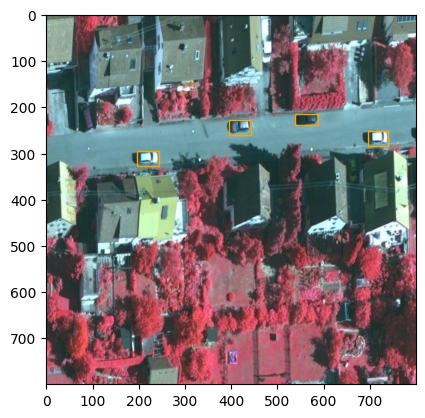

Prediction :  [9 9 9 9 9 9]


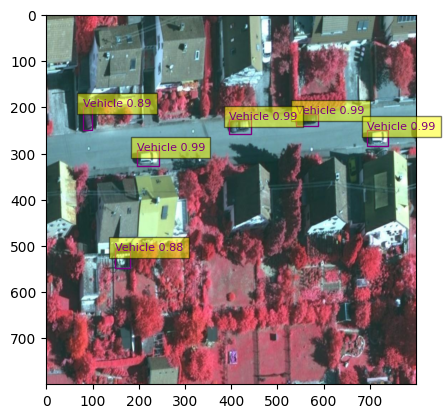

In [ ]:
def unnormalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    image = image * std + mean  # Unnormalize
    image = image.clip(0, 1)  # Ensure the pixel values are within [0, 1]
    return image
_idx =42
print("Target : ", annotations[_idx]['labels'])
plot_image_from_output1(unnormalize(imgs[_idx]), annotations[_idx])
for key in pred[_idx]:
    if isinstance(pred[_idx][key], torch.Tensor):
        pred[_idx][key] = pred[_idx][key].cpu()
print("Prediction : ", pred[_idx]['labels'].cpu().numpy())
plot_image_from_output(unnormalize(imgs[_idx]).cpu(), pred[_idx])

In [ ]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im , 'cpu', 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

100%|██████████| 1/1 [01:21<00:00, 81.88s/it]


In [ ]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data FaceMaskDetection
!unzip -q Face\ Mask\ Detection.zip

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 45 (delta 18), reused 17 (delta 5), pack-reused 0
Receiving objects: 100% (45/45), 11.62 KiB | 11.62 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Downloading...
From (original): https://drive.google.com/uc?id=16Gzn1w38yZLJpzmzKcRIRveFeHZtCEr7
From (redirected): https://drive.google.com/uc?id=16Gzn1w38yZLJpzmzKcRIRveFeHZtCEr7&confirm=t&uuid=7b19715a-5196-4af8-b93b-626f24e50267
To: /content/Face Mask Detection.zip
100% 417M/417M [00:08<00:00, 48.8MB/s]
Face Mask Detection.zip download complete!


In [ ]:
%cd Tutorial-Book-Utils/
import utils_ObjectDetection as utils

/content/Tutorial-Book-Utils


In [ ]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5)

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.7070636433263549
AP : tensor([0.0000, 0.7660, 0.9790, 0.9866, 0.6666, 0.6891, 0.8786, 0.7068, 0.5618,
        0.8361], dtype=torch.float64)


In [ ]:
%cd Tutorial-Book-Utils/
import utils_ObjectDetection as utils

/content/Tutorial-Book-Utils


In [ ]:
def bbox_iou(box1, box2):
    """ Calculate the Intersection over Union (IoU) of two bounding boxes. """
    b1_x1, b1_y1, b1_x2, b1_y2 = box1
    b2_x1, b2_y1, b2_x2, b2_y2 = box2

    inter_rect_x1 = max(b1_x1, b2_x1)
    inter_rect_y1 = max(b1_y1, b2_y1)
    inter_rect_x2 = min(b1_x2, b2_x2)
    inter_rect_y2 = min(b1_y2, b2_y2)

    inter_area = max(inter_rect_x2 - inter_rect_x1, 0) * max(inter_rect_y2 - inter_rect_y1, 0)
    b1_area = (b1_x2 - b1_x1) * (b1_y2 - b1_y1)
    b2_area = (b2_x2 - b2_x1) * (b2_y2 - b2_y1)
    union_area = b1_area + b2_area - inter_area

    iou = inter_area / union_area if union_area != 0 else 0
    return iou

In [ ]:
def calculate_precision_recall(gt_boxes, pred_boxes, pred_scores, iou_threshold=0.5):
    # Assume gt_boxes and pred_boxes are list of boxes [xmin, ymin, xmax, ymax]
    # pred_scores are the confidence scores of each prediction
    matches = []
    for i, pred_box in enumerate(pred_boxes):
        for gt_box in gt_boxes:
            if bbox_iou(pred_box, gt_box) >= iou_threshold:
                matches.append((i, bbox_iou(pred_box, gt_box)))

    # Sort by score to prioritize high confidence predictions in the evaluation
    matches.sort(key=lambda x: pred_scores[x[0]], reverse=True)

    true_positives = [0] * len(pred_boxes)
    for i, match in enumerate(matches):
        if i == 0 or match[0] != matches[i - 1][0]:
            true_positives[match[0]] = 1

    tp = sum(true_positives)
    fp = len(pred_boxes) - tp
    fn = len(gt_boxes) - tp

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    return precision, recall

In [ ]:
# Example to use the above functions
for images, targets in test_loader:
    images = list(image.to(device) for image in images)
    predictions = make_prediction(model, images, device, threshold=0.5)

    # Calculate for each image in the batch
    for i, prediction in enumerate(predictions):
        gt_boxes = targets[i]['boxes'].cpu().numpy()
        pred_boxes = prediction['boxes'].cpu().numpy()
        pred_scores = prediction['scores'].cpu().numpy()

        precision, recall = calculate_precision_recall(gt_boxes, pred_boxes, pred_scores, iou_threshold=0.5)
        print(f"Precision: {precision}, Recall: {recall}")

Precision: 1.0, Recall: 1.0
Precision: 0.5, Recall: 1.0
Precision: 1.0, Recall: 1.0
Precision: 0.8333333333333334, Recall: 1.0
Precision: 0.7777777777777778, Recall: 0.9333333333333333
Precision: 0.6666666666666666, Recall: 1.0
Precision: 1.0, Recall: 0.8333333333333334
Precision: 0.3333333333333333, Recall: 1.0
Precision: 1.0, Recall: 1.0
Precision: 1.0, Recall: 0.8333333333333334
Precision: 0.8571428571428571, Recall: 1.0
Precision: 0.5, Recall: 1.0
Precision: 0.2857142857142857, Recall: 0.5714285714285714
Precision: 0.9090909090909091, Recall: 0.8333333333333334
Precision: 1.0, Recall: 0.75
Precision: 0.5714285714285714, Recall: 1.3333333333333333
Precision: 0.4, Recall: 1.0
Precision: 1.0, Recall: 1.0
Precision: 0.9090909090909091, Recall: 1.0
Precision: 1.0, Recall: 1.0
Precision: 0.9166666666666666, Recall: 1.0
Precision: 0.6, Recall: 1.0
Precision: 0.75, Recall: 0.75
Precision: 1.0, Recall: 1.0
Precision: 0.6666666666666666, Recall: 0.6666666666666666
Precision: 0.33333333333333